**Advanced Fraud Detection Using Convolutional Neural Network**

Fraud detection has become an integral part of the financial sector. Due to the constant innvovation and grandeur of payments/financial solutions, the ability to detect fraudulent activities in transactions will also need to follow suite in its design and implementation. In this notebook, we explore the design of an advanced fraud detection system utilizing a convolutional neural network architecture.

**Dataset**

The dataset being utilized is a synthetic dataset of a simulation of mobile money transactions based on a month's logs of financial transactions by a payment service in an African country.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('dark')
sns.set_color_codes()

In [2]:
#Read data
df=pd.read_csv('fraud_detection_data.csv')

In [3]:
#First 5 rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#Last 5 rows
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [5]:
#Shape of dataset
df.shape

(6362620, 11)

Our dataset contains over 6 million rows of data with 11 columns.

Gathering some more statistical info about our data.

In [6]:
#Understanding the data type distribution of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
#Statistical information and distribution of columns in dataset
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Checking for null values in our dataset.

In [8]:
#Checking for null values in columns of dataset
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Dataset is void of null values. Next we explore our columns individually what they mean and their significance to the model building processing.

In [9]:
#Let us see the columns in our dataset once again
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Understanding each column and what they represent.

|Column |Description|
|-----|:-----|
|Step |Maps a unit of time in the real world. In this case, one step is one hour of time.|
|Type |Type of transaction, Could be CASH_IN, CASH_OUT, DEBIT, PAYMENT and TRANSFER.|
|Amount|Amount of transaction in local currency.|
|NameOrig|Customer who started the transaction.|
|OldBalanceOrg|Initial balance before the transaction.|
|NewBalanceOrig|Customer's balance after the transaction.|
|NameDest|Recipient ID of the transaction.|
|OldBalanceDest|Initial recipient balance before the transaction.|
|NewBalanceDest|Recipient's balance after the transaction.|
|IsFraud|Identifies a fraudulent transaction (1) and non fraudulent transaction (0).|
|IsFlaggedFraud|Flags illegal attempts to transfer more than 200,000 in a single transaction.|

Exploring what percentage of our data are actually fraudulent transactions to get an idea of the distribution of our dataset

In [10]:
len(df[df['isFraud']==1])/len(df) * 100

0.12908204481801522

Barely 0.1% of our dataset are actual fraudulent transactions, this means there will be need to implement some sampling technique to handle the unevennnes of the dataset.

**Exploratory Data Analysis**

Exploring the dataset to gain insights into its different features and how they relate to each other.

*Type*

In [11]:
#Transaction types being considered in dataset
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

The type of transactions considered are:
* PAYMENT
* TRANSFER
* CASH_OUT
* CASH_IN

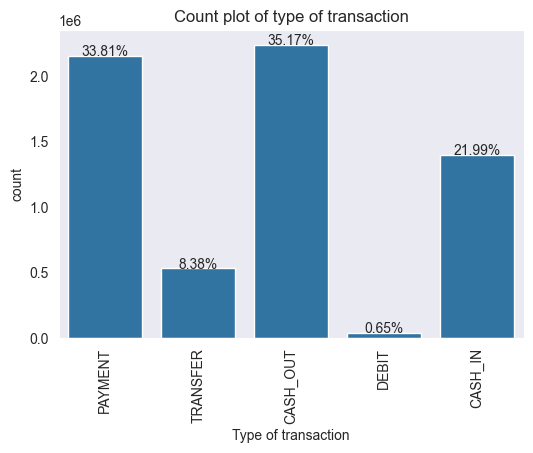

In [12]:
#Percentage of each transaction type in dataset visualized in a count plot
plt.figure(figsize=(6,4))
total=float(len(df['type']))
sen=sns.countplot(x='type', data=df)
for g in sen.patches:
    height=g.get_height()
    sen.text(g.get_x()+g.get_width()/2, height+3, '{:1.2f}%'.format((height/total)*100), ha='center')
plt.title('Count plot of type of transaction')
plt.xlabel('Type of transaction')
plt.xticks(rotation=90)
plt.show()

From our bar plot, we can observe that a bulk of our transactions are either cash_out or payment transactions while debit transactions are the least occurring. It would be useful to see what percentage of each transaction types are actually fraudulent transactions.

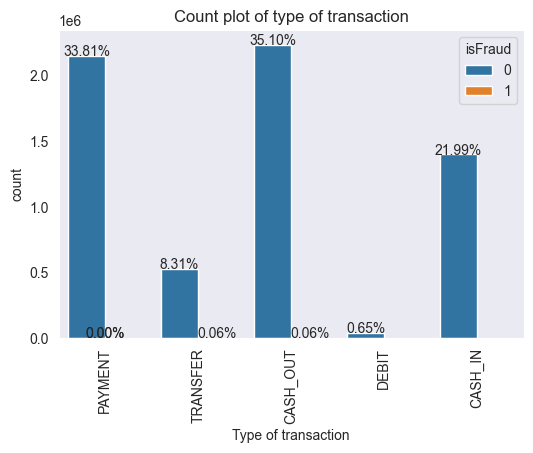

In [13]:
#Percentage of each transaction type by fraud activities visualized in a count plot
plt.figure(figsize=(6,4))
total=float(len(df['type']))
sen=sns.countplot(x='type', data=df, hue='isFraud', orient='y')
for g in sen.patches:
    height=g.get_height()
    sen.text(g.get_x()+g.get_width()/2, height+3, '{:1.2f}%'.format((height/total)*100), ha='center')
plt.title('Count plot of type of transaction')
plt.xlabel('Type of transaction')
plt.xticks(rotation=90)
plt.show()

From our plot, the amount of fraudulent activities for each transaction type is rather miniscule, this is expected considering the fact that barely 0.1% of our dataset is composed of actual fraudulent transactions. Some sampling technique would need to be adopted during feature engineering/model building to deal with this.

*Amount*


Let us explore the minimum and maximum amount of transaction in our dataset.

In [14]:
#Getting minimum amount
min_amount=str(np.min(df['amount']))
print(f'The minimum transaction amount is, {min_amount}')

The minimum transaction amount is, 0.0


In [15]:
#Getting maximum amount
max_amount=str(np.max(df['amount']))
print(f'The maximum transaction amount is, {max_amount}')



The maximum transaction amount is, 92445516.64


We can use a box plot to visualize some useful statistics about the amount column.

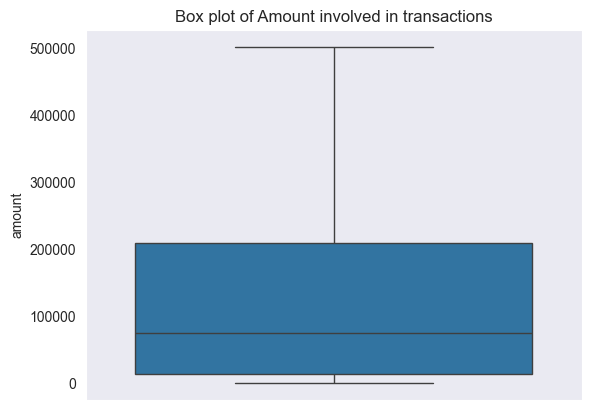

In [16]:
#Plotting a boxplot of the amount column
sns.boxplot(df['amount'], showfliers=False)
plt.title('Box plot of Amount involved in transactions')
plt.show()

Box plot amount shows that we have a median amount of about 100,000 for all transactions in dataset. Next, we will only pick fraudulent transactions to see what the box plot might tell us.

In [17]:
#Creating a dataframe with fraudulent transactions
df_is_fraud=df[df['isFraud']==1]

In [18]:
#Getting the size of dataframe with only fraudulent transactions
len(df_is_fraud)

8213

We have 8213 fraudulent transactions in our dataset.

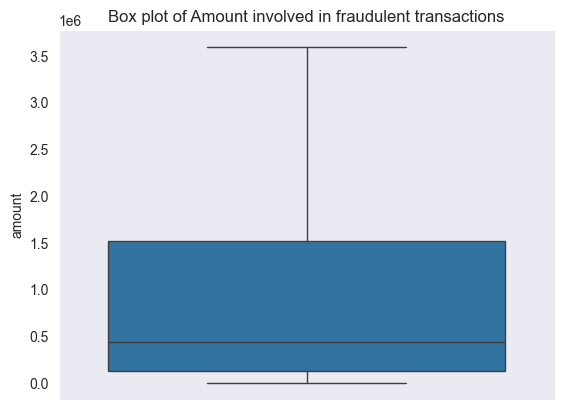

In [19]:
#Box plot of fraudulent transactions
sns.boxplot(df_is_fraud['amount'], showfliers=False)
plt.title('Box plot of Amount involved in fraudulent transactions')
plt.show()

The median amount for fraudulent transactions is about 500,000 which is almost 5 times what was observed above.From our observation, transactions with fraudulent activities seem to involve more money than the average transaction would. We can go ahead to plot a histogram of our fraudulent transaction amounts to investigate the distribution.

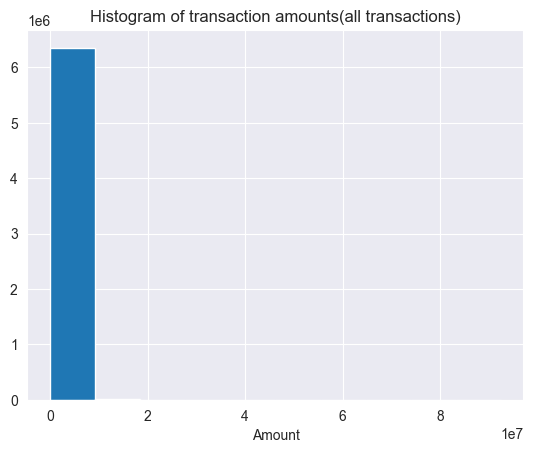

In [20]:
df['amount'].hist()
plt.title('Histogram of transaction amounts(all transactions)')
plt.xlabel('Amount')
plt.show()

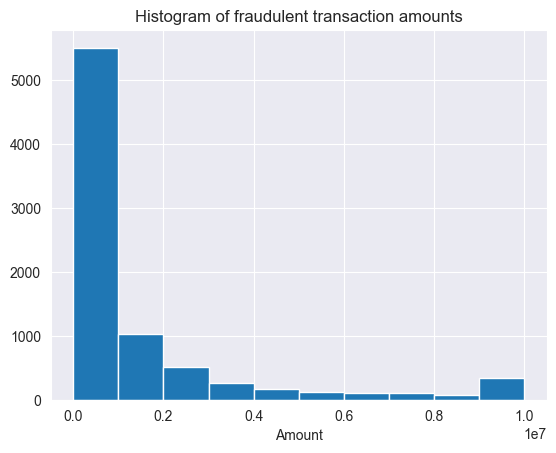

In [21]:
df_is_fraud['amount'].hist()
plt.title('Histogram of fraudulent transaction amounts')
plt.xlabel('Amount')
plt.show()

We observe a right skewed distribution with a mode between 0 and 1,000,000. Let us see the largest amount for a fraudulent transaction.

In [22]:
#Getting maximum amount for fraudulent transactions
max_amount=str(np.max(df_is_fraud['amount']))
print(f'The maximum transaction amount for a fraudulent transaction is, {max_amount}')


The maximum transaction amount for a fraudulent transaction is, 10000000.0


Let's see how the amount for fraudulent transactions differ across the various types of transactions, but first we will explore the count of each transaction type that had fraudulent activity.

In [23]:
#Types of fraudulent transactions
df_is_fraud['type'].value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

It seems our fraudulent transactions are either CASH_OUT or TRANSFER transactions, other categories which exist in the dataset do not have fraudulent transactions listed for them. 

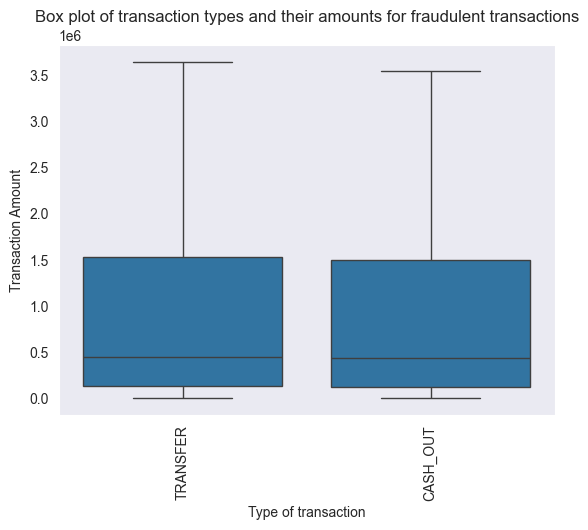

In [24]:
sns.boxplot(data=df_is_fraud, x='type', y='amount', showfliers=False)
plt.title('Box plot of transaction types and their amounts for fraudulent transactions')
plt.xlabel('Type of transaction')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=90);

Data distribution for both transfer and cash out fraudulent transactions seems about the same except the occurrence of a higher maximum amount for transfer compared to cash out transactions.

*OldBalanceOrg*


Text(0.5, 0, 'Initial Balance before the transaction')

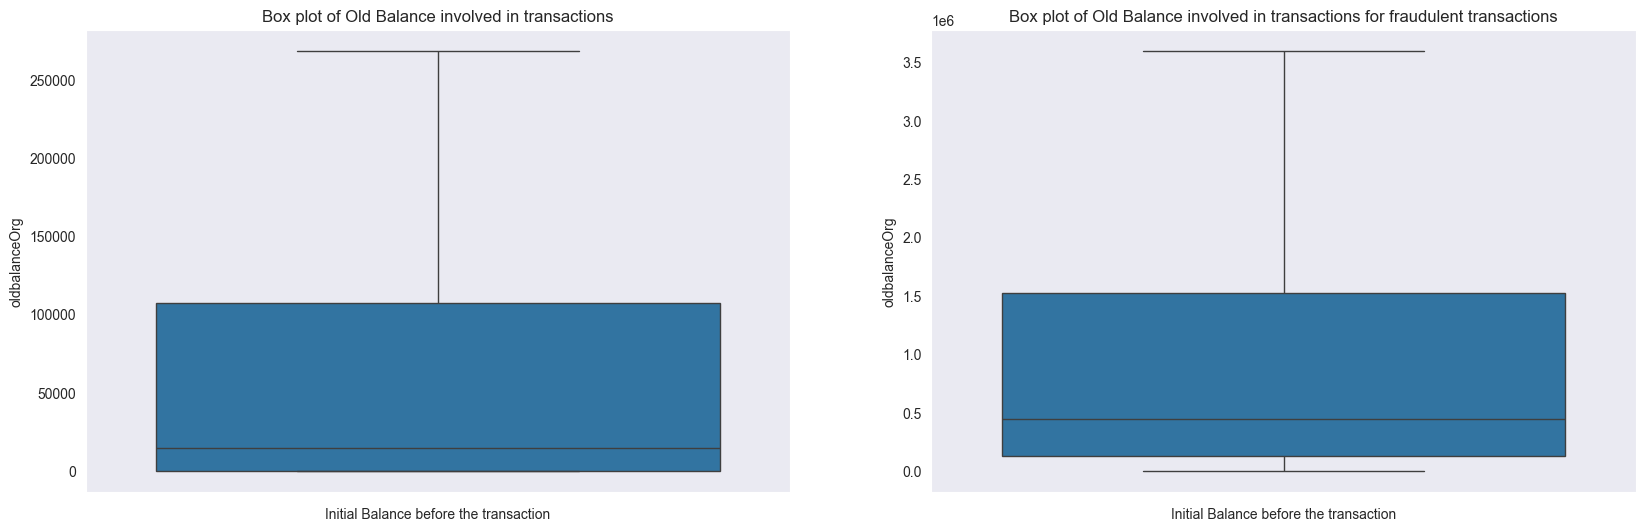

In [25]:
#Doing a side by side comparison of old balances for fraudulent transactions and all transactions in the dataset
plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.boxplot(df['oldbalanceOrg'], showfliers=False)
plt.title('Box plot of Old Balance involved in transactions')
plt.xlabel('Initial Balance before the transaction')

plt.subplot(1,2,2)
sns.boxplot(df_is_fraud['oldbalanceOrg'], showfliers=False)
plt.title('Box plot of Old Balance involved in transactions for fraudulent transactions')
plt.xlabel('Initial Balance before the transaction')

A side by side comparison shows that in general, accounts that perpetrate fraudulent transactions hold a higher amount of money before transactions are initiated compared to the average accounts.

Text(0.5, 0, 'Balance after the transaction')

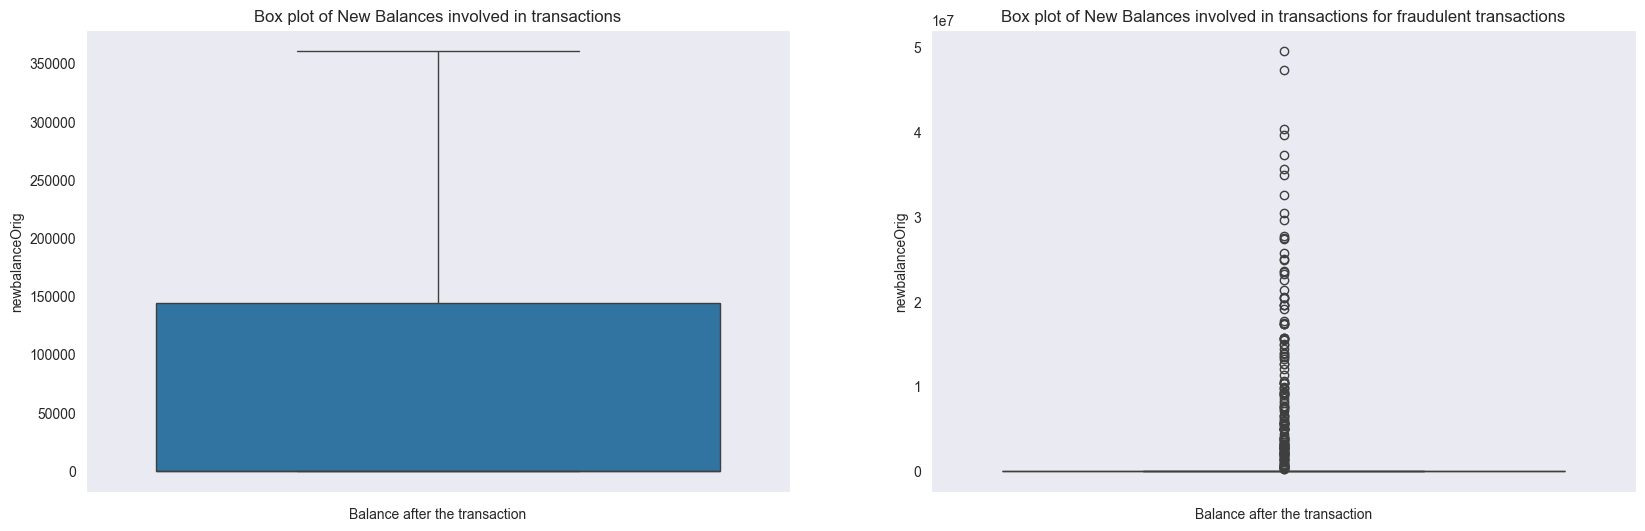

In [26]:
#Doing a side by side comparison of balances after transactions for fraudulent transactions and all transactions in the dataset
plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.boxplot(df['newbalanceOrig'], showfliers=False)
plt.title('Box plot of New Balances involved in transactions')
plt.xlabel('Balance after the transaction')

plt.subplot(1,2,2)
sns.boxplot(df_is_fraud['newbalanceOrig'])
plt.title('Box plot of New Balances involved in transactions for fraudulent transactions')
plt.xlabel('Balance after the transaction')

The median new balance for both categories is 0.0. However for fraudulent transactions, there seems to be the presence of outlier new balances.

*IsFlaggedFraud*

In [27]:
#How many transactions were flagged as fraud
df_is_flagged_fraud=df[df['isFlaggedFraud']==1]
len(df_is_flagged_fraud)

16

Sixteen transactions were flagged as involving fraudulent transactions but were they actually fraudulent transactions?

In [28]:
# Checking to see if all flagged transactions were actually fraudulent
len(df_is_flagged_fraud[df_is_flagged_fraud['isFraud']==1])

16

Looks like all transactions that were flagged as illegal were actually fraudulent. Let us the see the distribution of the amount for the flagged transactions.


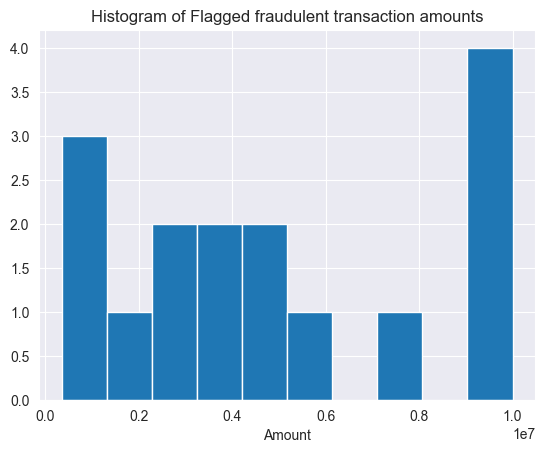

In [29]:
df_is_flagged_fraud['amount'].hist()
plt.title('Histogram of Flagged fraudulent transaction amounts')
plt.xlabel('Amount')
plt.show()

From our histogram, it looks like we have a left skewed distrbution with most amounts being over 10000000. Typically, flagged transactions have amounts over 200,000, let us see how true that is.

In [30]:
#Getting minimum amount
min_amount_flagged=str(np.min(df_is_flagged_fraud['amount']))
print(f'The minimum transaction amount for flagged transactions is, {min_amount_flagged}')

The minimum transaction amount for flagged transactions is, 353874.22


Do we have transactions that were over 200,000 that were not flagged but were fraudulent? Let us see how many they are.

In [31]:
#Number of transactions with amounts over 200,000 that were fraudulent but were not flagged
len(df_is_fraud[df_is_fraud['amount']>=200000])

5471

We have over 5000 transactions with amounts greater than or equal to 200,000 that were fraudulent but were not flagged. What distinguishes the 16 illegal attempts from the other over 5000 transactions?

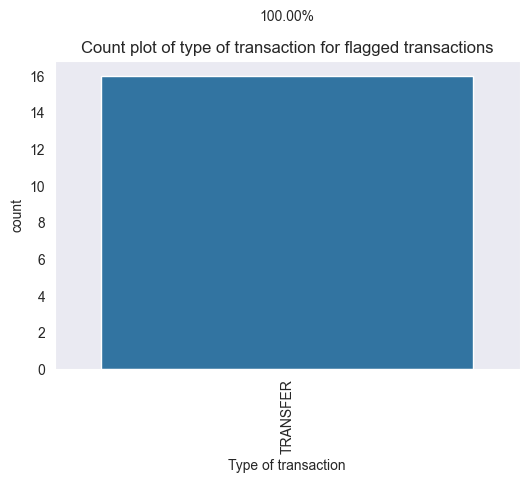

In [32]:
plt.figure(figsize=(6,4))
total=float(len(df_is_flagged_fraud['type']))
sen=sns.countplot(x='type', data=df_is_flagged_fraud)
for g in sen.patches:
    height=g.get_height()
    sen.text(g.get_x()+g.get_width()/2, height+3, '{:1.2f}%'.format((height/total)*100), ha='center')
plt.title('Count plot of type of transaction for flagged transactions')
plt.xlabel('Type of transaction')
plt.xticks(rotation=90)
plt.show()

All flagged transactions are transfer transactions. Although that is not enough reason, the flagging of illegal attempts sheds more light into some system in place to check for fraudulence. Possibly a type of fraud prevention system.

Testing for linear correlation between features using pearson correlation and visualizing on a heatmap.

<Axes: >

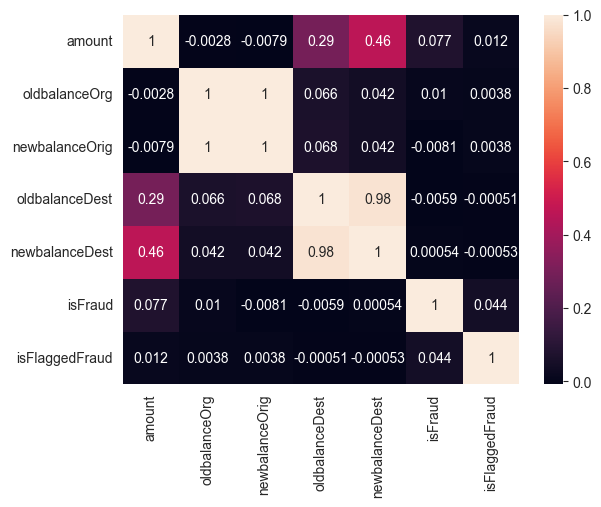

In [33]:
#A heatmap of the pearson correlation between the numeric features of our dataset
sns.heatmap(data=df[['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']].corr(), annot=True)

From our heatmap, there is an obvious strong positive linear correlation between the 'oldbalanceDest' variable and the 'newbalanceDest' variables as well as the 'oldbalanceOrg' and 'newbalanceOrig' variables. To avoid multicollinearity, it might necessary to choose either of these features during feature selection before model building.

**Feature Selection And Engineering**

There is high level of skewness observed in the numeric variables, log transformation will be applied to create normally distributed variables.

In [34]:
#Getting numeric variables
float_cols=[cols for cols in df.columns if df[cols].dtype=='float64' or df[cols].dtype=='int64']

In [35]:
float_cols

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [36]:
#Columns to which log transformation is to be applied
log_transform=['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [37]:
#Applying log transformation
for i in log_transform:
    df[i]=np.log(df[i])
    print(df[i].skew())

c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\pandas\core\nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


nan
nan
nan
nan
nan


In [38]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9.194174,C1231006815,12.044353,11.984780,M1979787155,-inf,-inf,0,0
1,1,PAYMENT,7.530630,C1666544295,9.964065,9.872240,M2044282225,-inf,-inf,0,0
2,1,TRANSFER,5.198497,C1305486145,5.198497,-inf,C553264065,-inf,-inf,1,0
3,1,CASH_OUT,5.198497,C840083671,5.198497,-inf,C38997010,9.960907,-inf,1,0
4,1,PAYMENT,9.364617,C2048537720,10.634749,10.305141,M1230701703,-inf,-inf,0,0
5,1,PAYMENT,8.964147,C90045638,10.894143,10.737316,M573487274,-inf,-inf,0,0
6,1,PAYMENT,8.868944,C154988899,12.118306,12.078735,M408069119,-inf,-inf,0,0
7,1,PAYMENT,8.969751,C1912850431,12.078735,12.033061,M633326333,-inf,-inf,0,0
8,1,PAYMENT,8.300121,C1265012928,7.890208,-inf,M1176932104,-inf,-inf,0,0
9,1,DEBIT,8.582563,C712410124,10.638736,10.501836,C195600860,10.642993,10.605317,0,0


In [39]:
#Replace the negative and positive infinity with 0
df.replace([np.inf, -np. inf], 0, inplace=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9.194174,C1231006815,12.044353,11.984780,M1979787155,0.000000,0.0,0,0
1,1,PAYMENT,7.530630,C1666544295,9.964065,9.872240,M2044282225,0.000000,0.0,0,0
2,1,TRANSFER,5.198497,C1305486145,5.198497,0.000000,C553264065,0.000000,0.0,1,0
3,1,CASH_OUT,5.198497,C840083671,5.198497,0.000000,C38997010,9.960907,0.0,1,0
4,1,PAYMENT,9.364617,C2048537720,10.634749,10.305141,M1230701703,0.000000,0.0,0,0


Next, we drop step, source and destination IDs of the transactions since these may not be too useful.

In [40]:
#Drop columns not needed
df.drop(columns=['step','nameOrig', 'nameDest'], inplace=True)

In [41]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9.194174,12.044353,11.984780,0.000000,0.0,0,0
1,PAYMENT,7.530630,9.964065,9.872240,0.000000,0.0,0,0
2,TRANSFER,5.198497,5.198497,0.000000,0.000000,0.0,1,0
3,CASH_OUT,5.198497,5.198497,0.000000,9.960907,0.0,1,0
4,PAYMENT,9.364617,10.634749,10.305141,0.000000,0.0,0,0


Encoding categorical variables using one hot coding. This is perfect because we do not have to necessarily worry about its effects on the dimensionality of our data.

In [42]:
#Encoding categorical variables
df=pd.get_dummies(df, dtype=int)

In [43]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9.194174,12.044353,11.984780,0.000000,0.0,0,0,0,0,0,1,0
1,7.530630,9.964065,9.872240,0.000000,0.0,0,0,0,0,0,1,0
2,5.198497,5.198497,0.000000,0.000000,0.0,1,0,0,0,0,0,1
3,5.198497,5.198497,0.000000,9.960907,0.0,1,0,0,1,0,0,0
4,9.364617,10.634749,10.305141,0.000000,0.0,0,0,0,0,0,1,0


Rearranging our columns so that our dependent variable 'isFraud' appears last. This will aid splitting of our data and eventual model building.

In [44]:
#Column redefinition
df=df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'isFlaggedFraud', 'isFraud']]

In [45]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFlaggedFraud,isFraud
0,9.194174,12.044353,11.984780,0.000000,0.0,0,0,0,1,0,0,0
1,7.530630,9.964065,9.872240,0.000000,0.0,0,0,0,1,0,0,0
2,5.198497,5.198497,0.000000,0.000000,0.0,0,0,0,0,1,0,1
3,5.198497,5.198497,0.000000,9.960907,0.0,0,1,0,0,0,0,1
4,9.364617,10.634749,10.305141,0.000000,0.0,0,0,0,1,0,0,0


From our initial analysis, it is obvious the data type of some columns may need to chane. For example, the data type of 'isFraud' which is an obviously categorical column wiould need to show that instead of 'int64' as well as 'isFlaggedFraud' and the different types of transactions which we one hot encoded.

In [46]:
#Giving columns the right data type
df['type_CASH_IN']=df['type_CASH_IN'].astype('category')
df['type_CASH_OUT']=df['type_CASH_OUT'].astype('category')
df['type_DEBIT']=df['type_DEBIT'].astype('category')
df['type_PAYMENT']=df['type_PAYMENT'].astype('category')
df['type_TRANSFER']=df['type_TRANSFER'].astype('category')
df['isFraud']=df['isFraud'].astype('category')
df['isFlaggedFraud']=df['isFlaggedFraud'].astype('category')

For feature selection, during our exploratory data analysis, we observed a possible multicollinearity problem between 4 columns. In order to select what column to feed into our algorotithm, we can use analysis of variance (ANOVA) to check their dependencies on the dependent varibale 'isFraud'.

In [47]:
#Applying ANOVA between numeric variables and our dependent variable
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit_transform(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']], df['isFraud'])
fs.scores_

array([10518.44760654,  7608.94146443,  5267.13784683,  1900.76135429,
         373.2739068 ])

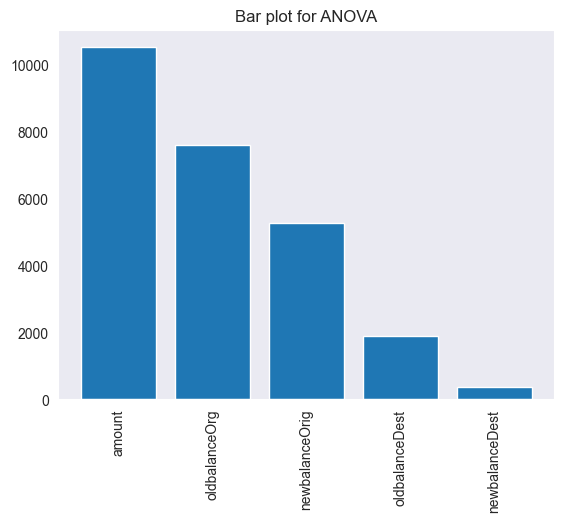

In [48]:
# Visualizing ANOVA scores using a bar plot 
plt.bar(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].columns, fs.scores_)
plt.xticks(rotation=90)
plt.title('Bar plot for ANOVA');

Now there was strong linear correlation between the 'oldbalanceOrg' and 'newbalanceOrig' and the 'oldbalanceDest' and 'newbalanceDest' columns. From our ANOVA analysis, there is stronger dependency between the 'oldbalanceOrg', 'oldbalanceDest' columns and the dependent variable than their counterparts. So we will choose them.

In [49]:
#Dropping the 'newbalanceOrig' and 'newbalanceDest' columns
df.drop(columns=['newbalanceOrig','newbalanceDest'], inplace=True)


In [50]:
df.head()

,amount,oldbalanceOrg,oldbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFlaggedFraud,isFraud
0,9.194174,12.044353,0.000000,0,0,0,1,0,0,0
1,7.530630,9.964065,0.000000,0,0,0,1,0,0,0
2,5.198497,5.198497,0.000000,0,0,0,0,1,0,1
3,5.198497,5.198497,9.960907,0,1,0,0,0,0,1
4,9.364617,10.634749,0.000000,0,0,0,1,0,0,0


The last part of feature engineering would be the handling of the imbalance dataset. We implement a hybrid sampling technique where we simultaneously increase and decrease our minority and majority classes respectively. For this we will be making use of SMOTE for oversampling and random undersampler for undersampling.

In [51]:
#Getting our X and y variables
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

In [52]:
#Define oversample and undersample strategy
oversample = SMOTE(sampling_strategy=0.05)  
undersample = RandomUnderSampler(sampling_strategy=0.95) 

In [53]:
#Pipeline handles simultaneous oversample and undersample
pipeline = Pipeline(steps=[
    ('o', oversample),
    ('u', undersample)
])


In [54]:
# Fit and transform the  data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

In [55]:
#Comparing the counts of both classes to test for balance
count_ones = np.count_nonzero(y_resampled)
count_zeros=np.count_nonzero(y_resampled==0)
print(f'Count of minority class(fraudulent transactions) is, {count_ones}')
print(f'Count of majority class(non-fraudulent transactions) is, {count_zeros}')

Count of minority class(fraudulent transactions) is, 317720
Count of majority class(non-fraudulent transactions) is, 334442


We can now move on to model building after resampling.

**Model Building**

To build our model, we will be making use of the keras module in tensorflow. First we will reshape our independent X variables to feed into the Conv1D neural network architecture

In [56]:
#Reshaping independent features by adding a channel dimension
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

In [57]:
#New shape of independent variable
X_resampled.shape

(652162, 9, 1)

Our CNN model comprises of 2 convolutional layers with 64 filters each. In addition, we have a flattened layer which feeds into a dense hidden layer with 50 units or neurons and finally an output layer with the sigmoid activation function which aids binary classification (what we are trying to achieve)

In [58]:
#Model definition
def base_cnn_model(input_shape):
    # Instantiate the Sequential model
    model = tf.keras.models.Sequential()
    
    # Add Convolutional layer (Convolution + Activation + Pooling)
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Add more Convolutional layers
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    
    # Flatten the output from the convolutional layers
    model.add(tf.keras.layers.Flatten())
    
    # Add Fully Connected layers
    model.add(tf.keras.layers.Dense(units=50, activation='relu'))
    #model.add(tf.keras.layers.Dense(units=1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    
    # Output layer with sigmoid activation for binary classification
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    # Compile the model with binary cross-entropy loss
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


KerasClassifier provides us the ability to combine the capabilities of scikit learn and the native model building techniques of tensorflow which is useful to carry out cross validation. Here, we will be training our model with a batch size of 100000 in 100 epochs.

In [59]:
# Create the KerasClassifier
input_shape=X_resampled.shape[1], 1
estimator = KerasClassifier(build_fn=base_cnn_model(input_shape), epochs=100, batch_size=100000, verbose=0)

c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using K fold cross validation with n=3 to evaluate the model and ensure it generalizes well with different data silos. Here, we use the f1 score because it provides us with a great evaluation metric considering both the precision and recall of the model. 

In [60]:
# Define KFold cross-validator
kfold = KFold(n_splits=3, shuffle=True)


# Perform cross-validation
results = cross_val_score(estimator, X_resampled, y_resampled, cv=kfold, scoring='f1')
print("Mean f1-score: %.2f%%" % (results.mean() * 100))

c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inn

Mean f1-score: 97.80%


After k fold cross validation, we arrived at an f1 score of 97.91%. We still want to gain insights into the confusion matrix of our model so we can evaluate the precision and recall values. To do this, let us split our data into training and test sets and then evaluate.

In [61]:
#Train-test-split
X_train, X_test, y_train, y_test = train_test_split( X_resampled, y_resampled, test_size=0.33, random_state=42)

In [62]:
#Build model
model=KerasClassifier(build_fn=base_cnn_model(input_shape), epochs=100, batch_size=100000, verbose=0)
model.fit(X_train, y_train)

c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\HP\Documents\Projects\Advanced-Fraud-Detection-System-Using-Convolutional-Neural-Network\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


KerasClassifier(
	model=None
	build_fn=<Sequential name=sequential_1, built=True>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=100000
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

In [63]:
y_preds=model.predict(X_test)

In [64]:
#Calculating mean squared error on predictions
print (f'The f1-score is {f1_score(y_test, y_preds)}')
print (f'The precision score is {precision_score(y_test, y_preds)}')
print (f'The recall score is {recall_score(y_test, y_preds)}')
print (f'The accuracy score is {accuracy_score(y_test, y_preds)}')
print (f'The ROC-AUC score score is {roc_auc_score(y_test, y_preds)}')




The f1-score is 0.9815440091788231
The precision score is 0.9661113825560278
The recall score is 0.9974776798461861
The accuracy score is 0.9816879942754654
The ROC-AUC score score is 0.9820528060789504


At the end of model evaluation, the metrics and scores realized are:
|Metric |Score|
|-----|:-----|
|Accuracy |98.066%|
|Precision |96.359%|
|Recall|99.787%|
|F1-score|98.054%|
|ROC-AUC score|98.106%|


In [65]:
confusion_matrix(y_test, y_preds)

array([[106476,   3676],
       [   265, 104797]], dtype=int64)